In [2]:
#dataframe
import pandas as pd

#plots
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
from sklearn import preprocessing

#model selection 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#model assessment
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

#dealing with class imbalance
from imblearn.under_sampling import RandomUnderSampler
#, RandomOverSampler

#tuning
from sklearn.model_selection import GridSearchCV

In [ ]:
#Planning to use logistic regression, KNN, Random Forest and maybe Gradient boosting

In [ ]:
#pip install -U imbalanced-learn

In [3]:
waze_cleaned = pd.read_csv("../data/waze_processed.csv")
waze_cleaned.head(3)

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8


<h3> Classes are inherently imbalanced

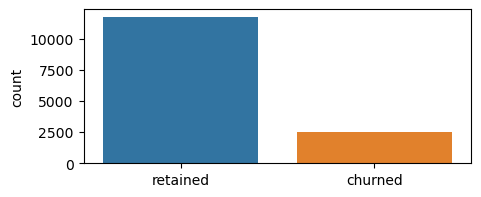

In [4]:
plt.figure(figsize = (5,2))
sns.countplot(x = waze_cleaned["label"])
plt.xlabel("");

In [5]:
retained_count = waze_cleaned['label'].value_counts().get("retained", 0)
churn_count = waze_cleaned['label'].value_counts().get("churned", 0)
churn_rate = churn_count/(churn_count+retained_count)
print("Total retained count:", retained_count)
print("Total churn count:", churn_count)
print("Churn rate", round(churn_rate, 2))

Total retained count: 11763
Total churn count: 2536
Churn rate 0.18


In [6]:
waze_cleaned['label']= waze_cleaned['label'].apply(lambda x: True if x == 'churned' else False).astype(int)
waze_cleaned.head(3)

,Android,iPhone,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days
0,1,0,0,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19
1,0,1,0,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11
2,1,0,0,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8


In [ ]:
#The above cells show that the data is unbalanced. 
#Successful modelling may necessitate resampling to balance classes. 

<h3> Split data into testing and training datasets and standardize

In [6]:
#Split data into testing and training datasets
X = waze_cleaned.drop('label', axis = 1)
y = waze_cleaned['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Standardize the magnitude of numeric features using a scaler
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [13]:
sampling_strategy = 0.5
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_train_scaled_res, y_res = rus.fit_resample(X_train_scaled, y_train)
y_train

12135    retained
8546     retained
10994    retained
11195    retained
13010    retained
           ...   
5191     retained
13418    retained
5390     retained
860      retained
7270     retained
Name: label, Length: 11439, dtype: object

In [19]:
plt.figure(figsize = (5,2))
sns.countplot(x = y_train[1])
plt.xlabel("");

ValueError: Could not interpret input 'retained'

<Figure size 500x200 with 0 Axes>

<h1> Logistic Regression

In [ ]:
#Instantiate the model and set parameters
#I also tried the newton_cg solver, but went with liblinear and l2 (default) (Ridge) regularization. Similar accuracy results
clf_lr = LogisticRegression(solver = 'liblinear', max_iter = 500, random_state = 45)

In [ ]:
#Fit the model using training set
clf_lr.fit(X_train_scaled, y_train)

In [ ]:
#Predict y test and check accuracy on predicting test set
y_predict = clf_lr.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = clf_lr.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

While checking for accuracy is only the first step, the well matched train/test accuracy (low variance, with only slightly higher accuracy for training set) is a good start with no obvious over/underfitting. I tried a confusion matrix and got array([[  34,  463],
       [  39, 2324]]), then different results, so went back and set a random state of 45 for consistent results

In [ ]:
cm = confusion_matrix(y_test, y_predict, labels = clf_lr.classes_)
cm

In [ ]:
# Define the grid of values for C
param_grid = {'C': np.logspace(-4, 4, 20)}

# Implement Grid Search
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

# Print the best C value
best_C = grid_search.best_params_['C']
print(f"The best C value is: {best_C}")

In [ ]:
# Define the grid of values for C
param_grid = {'C': np.logspace(-4, 4, 20)}

# Implement Grid Search
grid_search = GridSearchCV(estimator=clf_lr, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train_scaled, y_train)

# Print the best C value
best_C = grid_search.best_params_['C']
print(f"The best C value is: {best_C}")


In [ ]:
_, ax = plt.subplots()
display_cm = ConfusionMatrixDisplay(confusion_matrix = cm 
                                    , display_labels = ['churn', 'retain'])
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])

ax.set_xticklabels(labels = ['churn', 'retain'], fontsize = 8)
ax.set_yticklabels(labels = ['churn', 'retain'], fontsize = 8)
display_cm.plot(ax = ax);

In [ ]:
print(classification_report(y_test, y_predict))

<h1> K Nearest Neighbors 

In [ ]:
Ks = range(1,10)

table = pd.DataFrame(columns = ['K','Accuracy'])
table['K'] = Ks

j = 0
for K in Ks:
    
    # Apply Knn model to training data
    clf_knn = KNeighborsClassifier(n_neighbors = K)
    clf_knn.fit(X_train_scaled,y_train)
    
    # Predict using model
    y_pred_knn = clf_knn.predict(X_test_scaled)
    
    # Saving accuracy score in table
    table.iloc[j,1] = accuracy_score(y_test,y_pred_knn)
    j += 1
    
table  

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 9)
knn.fit(X_train_scaled,y_train)

y_pred = knn.predict(X_test_scaled)

In [ ]:
#Predict y test and check accuracy on predicting test set
y_predict = knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = knn.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

In [ ]:
#Use GridSearchCV to confirm best K value. Try a wider range

# Define the parameter grid: values of K to test
param_grid = {'n_neighbors': range(1, 20)}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Find the best parameters and use them to calculate accuracy on the test set
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)
best_accuracy = accuracy_score(y_test, y_pred_best)

# Output the best K value and corresponding accuracy
best_k = grid_search.best_params_['n_neighbors']
print('Best K value:', best_k) 
print('Best Accuracy:', best_accuracy)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 19)
knn.fit(X_train_scaled,y_train)

y_pred = knn.predict(X_test_scaled)

In [ ]:
#Predict y test and check accuracy on predicting test set
y_predict = knn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_predict)

#check accuracy of model on training set to check for over/underfitting
y_train_predicted = knn.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_predicted)

print("test accuracy:", test_accuracy)
print("train accuracy:", train_accuracy)

In [ ]:
report = classification_report(y_test, y_pred)
print(report)

<h2> Random Forest

In [ ]:
clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
model_res = clf_rf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)

ac = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print('Random Forest Accuracy = ', ac)
print('Random Forest f1-score =' , f1)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
feature_importance = clf_rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')
plt.show();